In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.final_preprocessing import serve_data

from models.transformer_encoder import TransEncoder
from models.baseline import BaseLineModel

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visualize_pca_tsne, visualize_all_customers
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Parameters

In [3]:
config_path = "./config_transcoder.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

n_feat = int(config["n_feat"])
num_customers = int(config["num_customers"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [4]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["re"],seq_len=seq_len, batch_size=batch_size_config)

In [5]:
next(iter(train_loader))[0].shape

torch.Size([32, 9883, 24])

# Model

In [6]:
if model_name == "TransEncoder":
    model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device, seq_len=seq_len)
if model_name == "BaseLine":
    model = BaseLineModel(seq_len=seq_len, hidden_dim=latent_dim, cond_dim=cond_features, cond_model=cond_model, device=device, channels=features)
    

ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Train

In [7]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, cond_data)
        loss.backward()
        
        optim.step()
        
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

 20%|██        | 1/5 [00:32<02:09, 32.31s/it]

Epoch: 1, Epoch Loss: 1.0129, RMSE: 1.1932


 40%|████      | 2/5 [00:58<01:25, 28.54s/it]

Epoch: 2, Epoch Loss: 1.0006


 60%|██████    | 3/5 [01:27<00:57, 28.70s/it]

Epoch: 3, Epoch Loss: 0.9954


 80%|████████  | 4/5 [01:55<00:28, 28.41s/it]

Epoch: 4, Epoch Loss: 0.9921


100%|██████████| 5/5 [02:22<00:00, 28.57s/it]

Epoch: 5, Epoch Loss: 0.9901


## Sampling

In [ ]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 321.03it/s]


Samples shape: (32, 9883, 24)


# Evaluation
## Without Conditioning
### Train

In [13]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([32, 10, 24]), torch.Size([32, 9883, 24]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


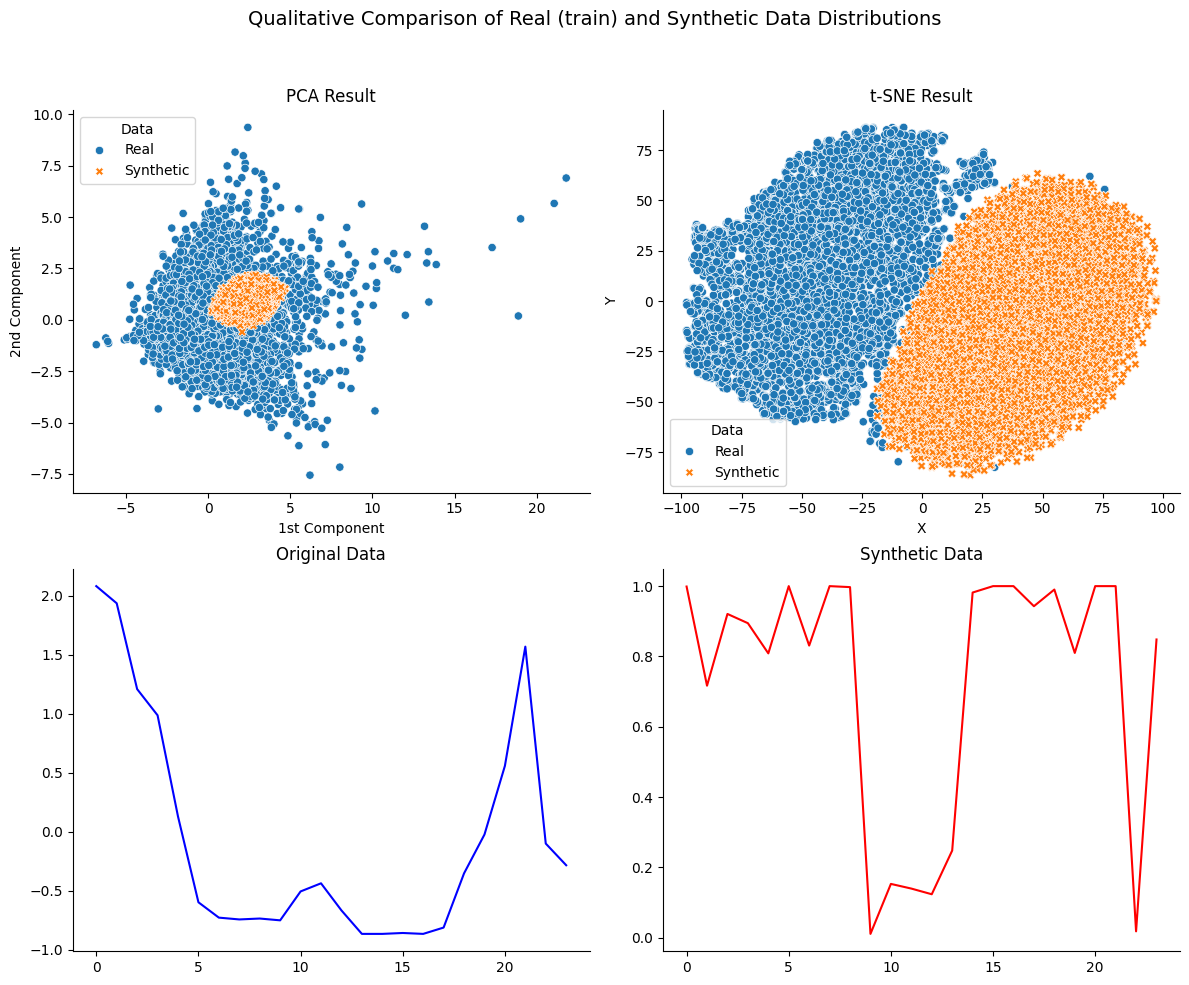

In [15]:
visualize_all_customers(ori_data=real_data_train, sample=samples, seq_len=seq_len, filename=log_file_name, cond=False, train_test="train", batch_size=batch_size_config)

In [ ]:
# train_customer_ids = random.sample(train_cols, num_customers)

# for idx, feature in enumerate(train_customer_ids):
#     real_feature = np.expand_dims(real_data_train[:, idx, :].cpu().numpy(), axis=-1)
#     gen_feature = np.expand_dims(samples[:, :, idx], axis=-1)
    
#     visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="train", filename=log_file_name, cond=False, feature=feature)

### Test

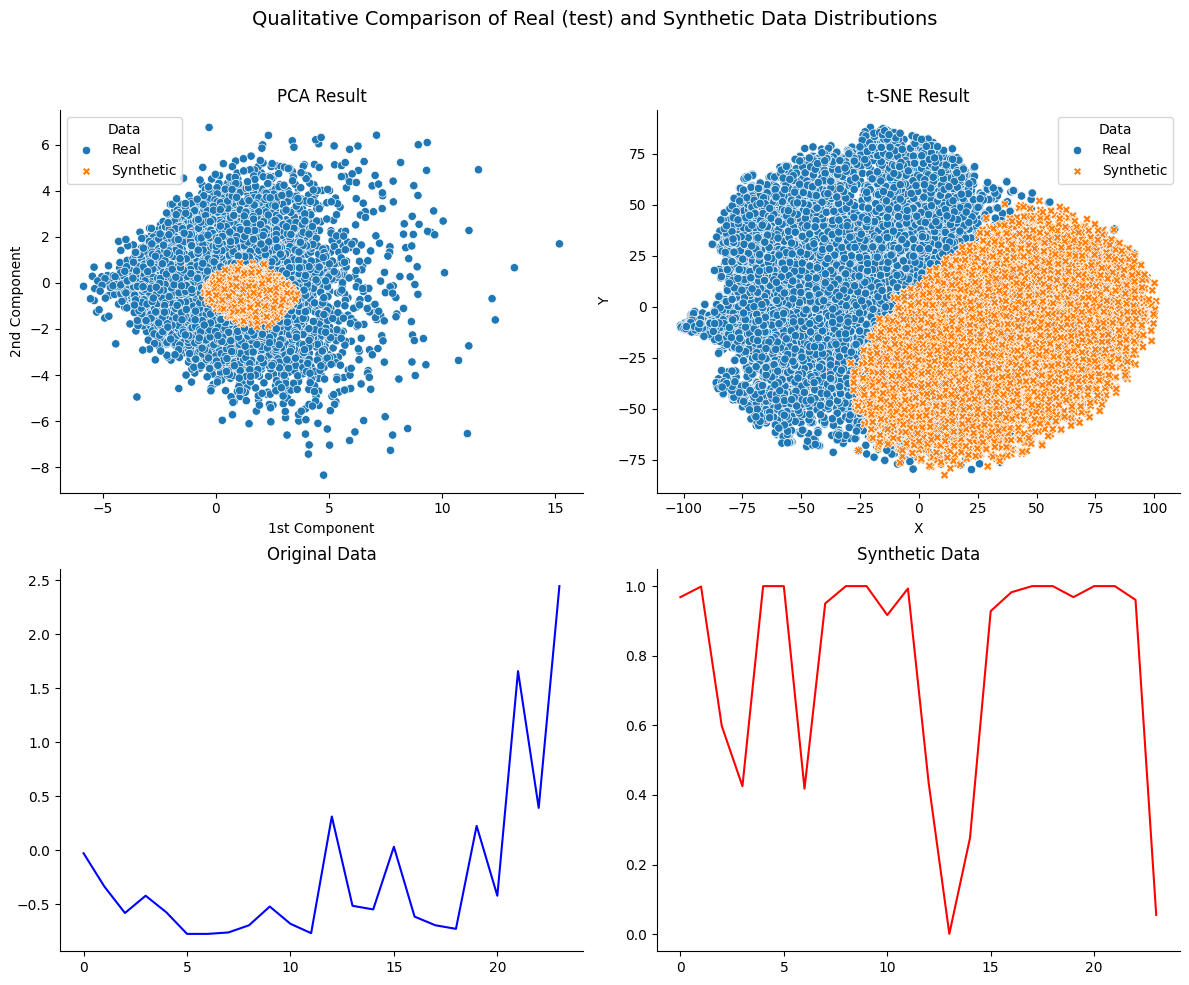

In [17]:
visualize_all_customers(ori_data=real_data_test, sample=samples, seq_len=seq_len, filename=log_file_name, cond=False, train_test="test", batch_size=batch_size_config)

In [ ]:
# test_customer_ids = random.sample(test_cols, num_customers)

# for idx, feature in enumerate(test_customer_ids):
#     real_feature = np.expand_dims(real_data_test[:, idx, :].cpu().numpy(), axis=-1)
#     gen_feature = np.expand_dims(samples[:, :, idx], axis=-1)
    
#     visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="test", filename=log_file_name, cond=False, feature=feature)

### Jensen-Shannon Divergence

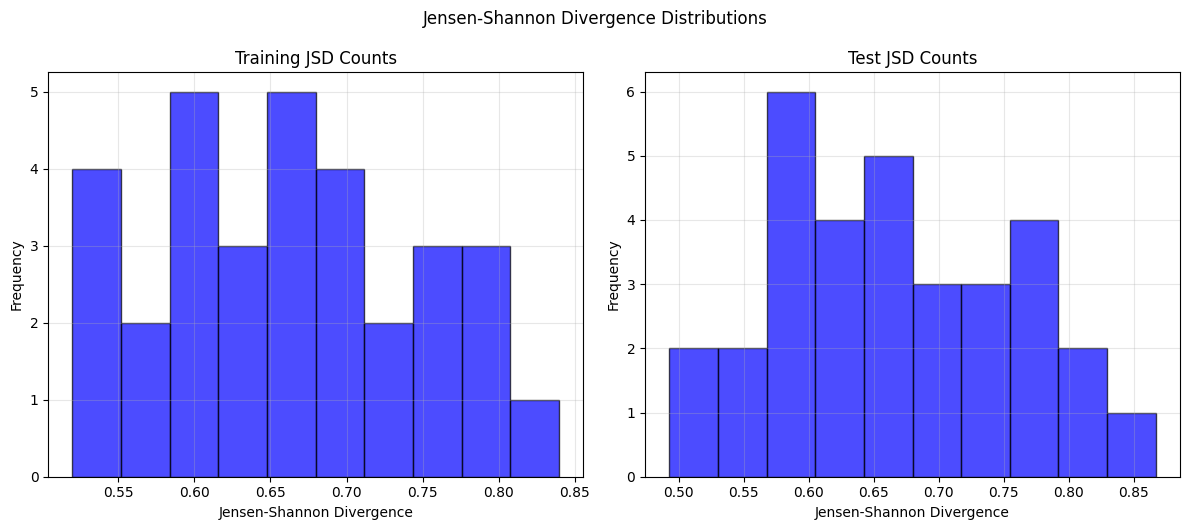

In [19]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

## With Conditioning

In [20]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()

print(f"Samples shape: {cond_samples_train.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 188.09it/s]

Samples shape: (32, 9883, 24)


## Train

### T-SNE and PCA

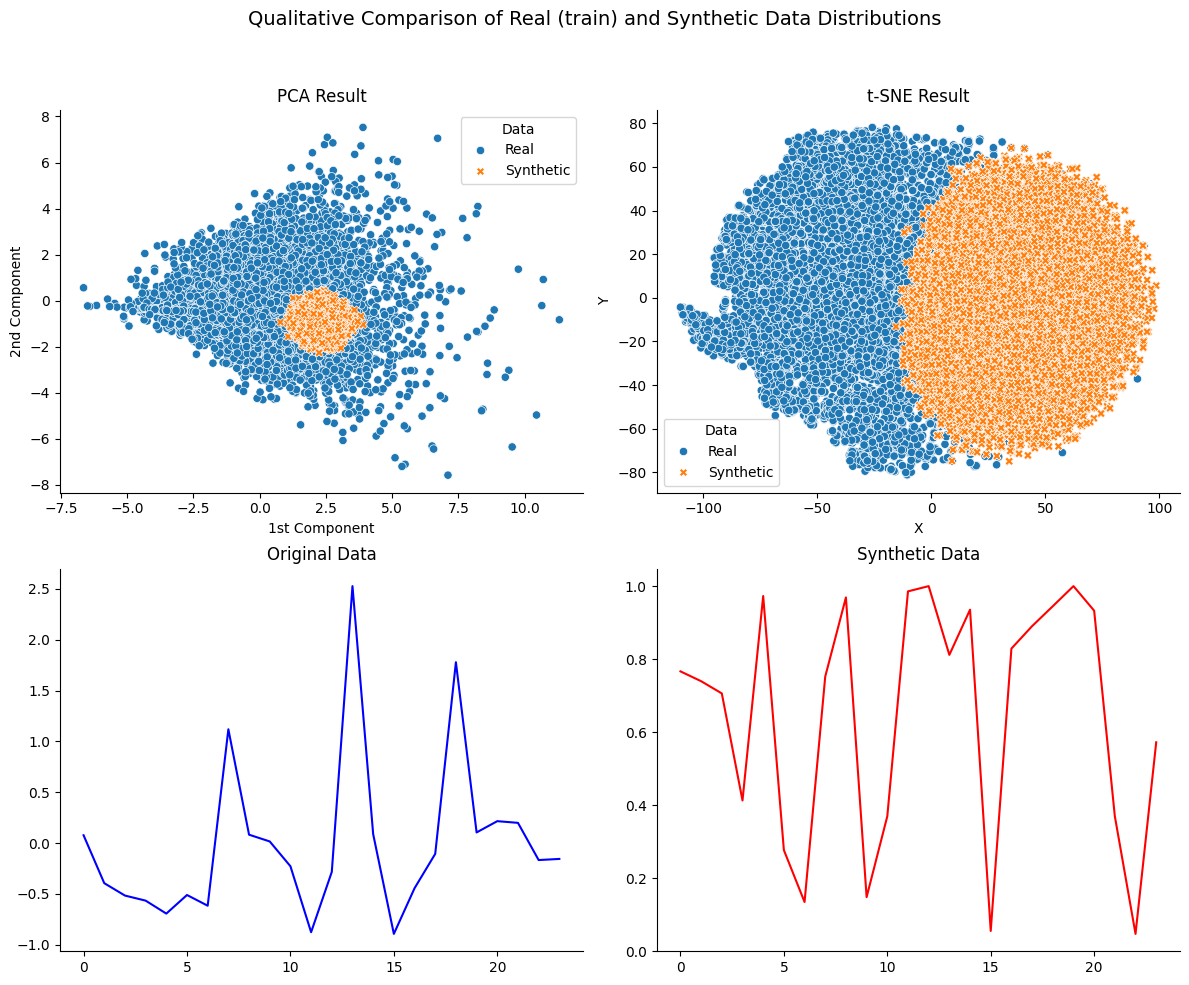

In [21]:
visualize_all_customers(ori_data=real_data_train, sample=cond_samples_train, seq_len=seq_len, filename=log_file_name, cond=True, train_test="train", batch_size=batch_size_config)

In [ ]:
# for idx, feature in enumerate(train_customer_ids):
#     real_feature = np.expand_dims(real_data_train[:, idx, :].cpu().numpy(), axis=-1)
#     gen_feature = np.expand_dims(cond_samples_train[:, :, idx], axis=-1)
    
#     visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="train", filename=log_file_name, cond=True, feature=feature)

### Jensen-Shannon-Divergence

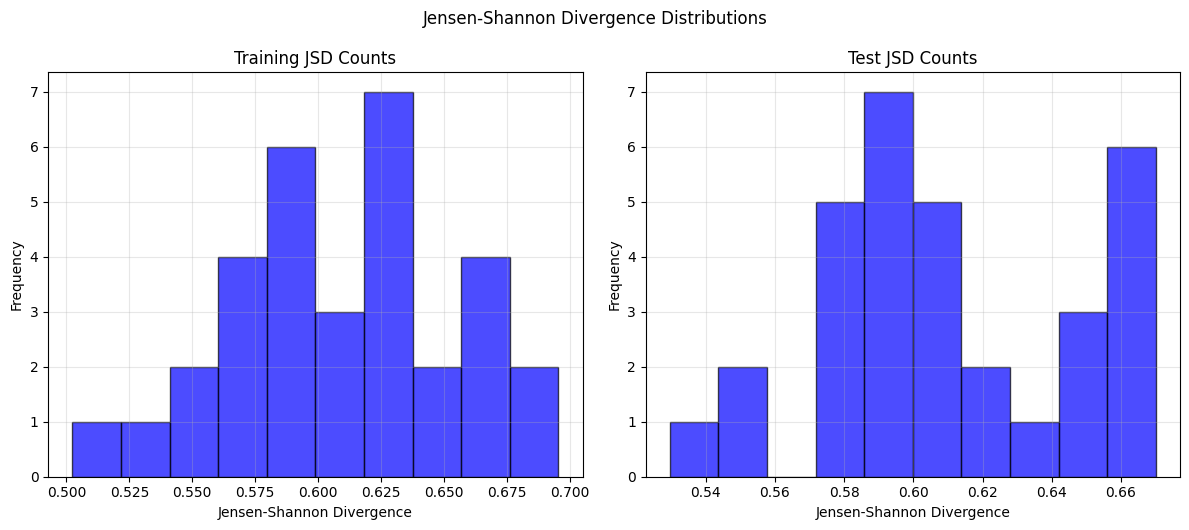

In [22]:
plot_jsd(real_data_train, real_data_test, cond_samples_train.transpose(0,2,1), log_file_name, cond=True)

## Test

In [23]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()

print(f"Samples shape: {cond_samples_test.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:04<00:00, 203.55it/s]

Samples shape: (32, 9883, 24)


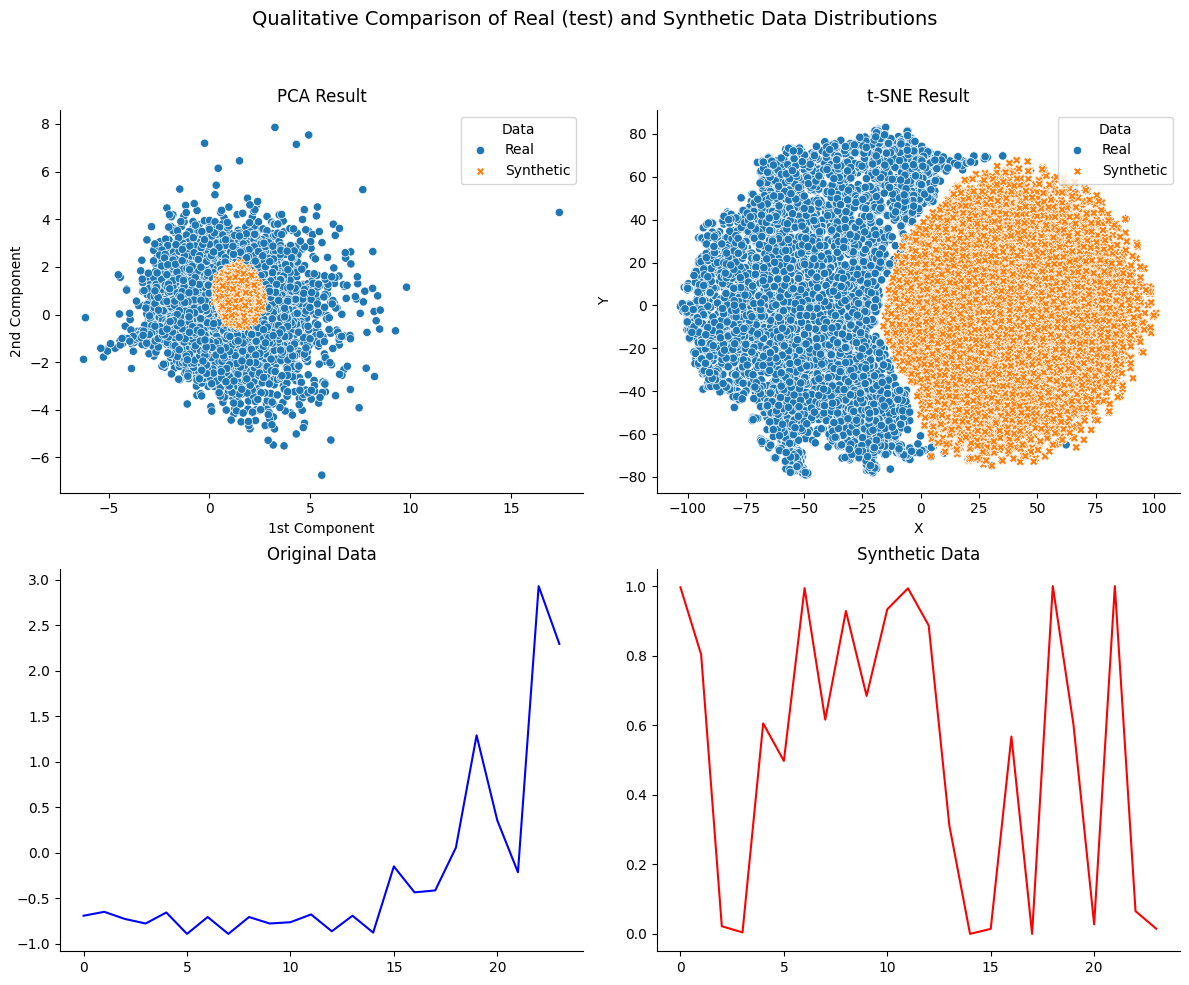

In [24]:
visualize_all_customers(ori_data=real_data_test, sample=cond_samples_test, seq_len=seq_len, filename=log_file_name, cond=True, train_test="test", batch_size=batch_size_config)

In [ ]:
# for idx, feature in enumerate(test_customer_ids):
#     real_feature = np.expand_dims(real_data_train[:, idx, :].cpu().numpy(), axis=-1)
#     gen_feature = np.expand_dims(cond_samples_test[:, :, idx], axis=-1)
    
#     visualize_pca_tsne(ori_data=real_feature, fake_data=gen_feature, seq_len=seq_len, train_test="test", filename=log_file_name, cond=True, feature=feature)

### Jensen-Shannon Divergence

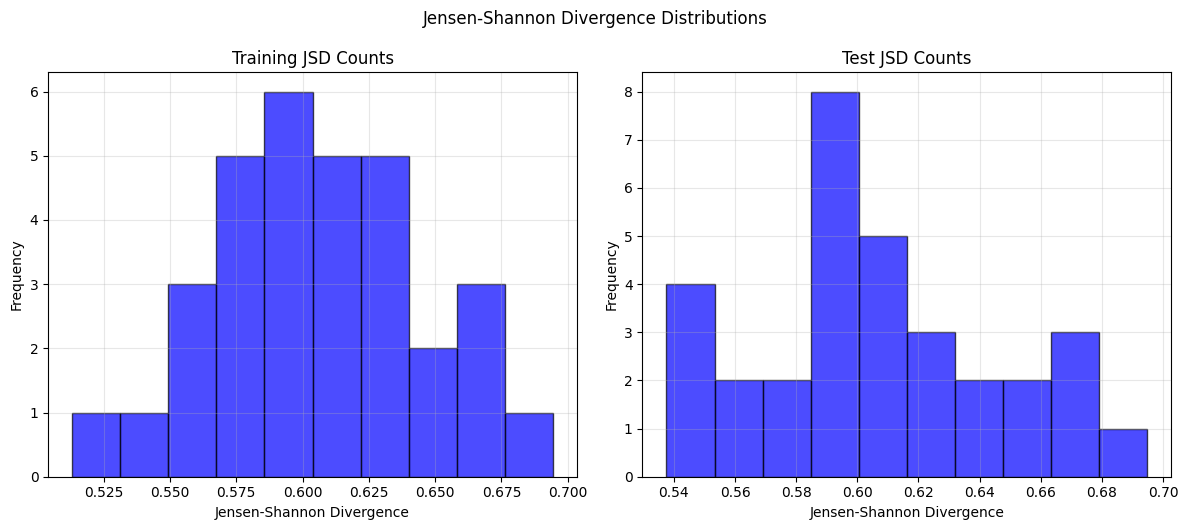

In [25]:
plot_jsd(real_data_train, real_data_test, cond_samples_test.transpose(0,2,1), log_file_name, cond=True)

# Logging

In [26]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\n\nRMSE Values:\n")
    for rmse in rmse_list:
        log_file.write(f"{rmse}\n")

print(f"Log file created at: {log_file_path}")

Log file created at: ./logging/logs\TransEncoder_te_2025-03-20-18-22.txt


In [ ]:
#best_model = torch.load("./logging/weights/TransEncoder_te_2025-02-19-19-39/best_model_weights.pth")